In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
from collections import OrderedDict
from itertools import compress
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata
from matplotlib import pyplot
from pylab import MaxNLocator
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import scipy.stats
#import seaborn as sns

In [2]:
master = pd.read_excel('../data/ASF_12well_coculture_sample_list_20170117.xlsx')
# remove experiment 3sp
master = master[master['Run'] != '3sp']
# replace NAs with 0s
master = master.fillna(0)
# replace the values in the species column with strings, for convenience
master['species'] = master['species'].astype('str')
# remove samples from experiments where the species did not grow
master = master[~((master['species'].str.contains('492')) & (master['Run'] == 3))]
master = master[~((master['species'].str.contains('500')) & (master['Run'] == 3))]
master = master[~((master['species'].str.contains('502')) & (master['Run'] == 3))]
master = master[~((master['species'].str.contains('502')) & (master['Run'] == 2))]

In [3]:
qpcr_cols = [x for x in master.columns if str(x).startswith('qpcr')]
# rename qPCR columns by species number code
new_qpcr_cols = {x:x[x.find('(')+1:x.find('(')+4] for x in qpcr_cols}
master = master.rename(columns=new_qpcr_cols)

In [4]:
# calculate avg and std dev of monocultures across all 3 experiments
# so that z-scores can be calculated for all co-cultures.
species = ['356','360','361','492','500','519']
for specie in species:
    # subset the dataframe to only include monocultures
    monoculture = master[master['species'] == specie]
    # get the mean qPCR value for the monoculture
    species_mean = monoculture[specie].mean()
    species_std = monoculture[specie].std()
    # create new z_score column for the species
    master[specie+'Z'] = (master[specie] - species_mean)/species_std

In [5]:
# Load the differential abundance testing results
master_w_testing = master.copy()
all_diff_abundance = []
for specie in species:
    filename = specie+'_diff_abundance.txt'
    diff_abundance = pd.read_csv('../results/'+filename,sep='\t')
    diff_abundance['species'] = [entry[1] for entry in diff_abundance.index.str.split(' vs. ')]
    diff_abundance['mono_comparison'] = [entry[0] for entry in diff_abundance.index.str.split(' vs. ')]
    diff_abundance['species'] = diff_abundance['species'].str.replace(',',';')
    all_diff_abundance.append(diff_abundance)
    #if all_diff_abundance == []:
    #    all_diff_abundance = pd.concat([all_diff_abundance,diff_abundance])
    #else:
    #    all_diff_abundance = diff_abundance
all_diff_abundance = pd.concat(all_diff_abundance)    
#master_w_testing = pd.merge(master_w_testing,diff_abundance,on='species',how='outer')
master = pd.merge(master,all_diff_abundance,on='species',how='outer')

In [6]:
# position_dict = {str(['502', '519']):[7],
# str(['500', '519']):[14],
# str(['500', '502']):[15],
# str(['492', '519']):[21],
# str(['492', '502']):[22],
# str(['492', '500']):[23],
# str(['361', '519']):[28],
# str(['361', '502']):[29],
# str(['361', '500']):[30],
# str(['361', '492']):[31],
# str(['360', '519']):[35],
# str(['360', '502']):[36],
# str(['360', '500']):[37],
# str(['360', '492']):[38],
# str(['360', '361']):[39],
# str(['356', '519']):[42],
# str(['356', '502']):[43],
# str(['356', '500']):[44],
# str(['356', '492']):[45],
# str(['356', '361']):[46],
# str(['356', '360']):[47]}

# new version of position dictionary excluding ASF502
position_dict = {str(['500', '519']):[0],
str(['492', '519']):[5],
str(['492', '500']):[6],
str(['361', '519']):[10],
str(['361', '500']):[11],
str(['361', '492']):[12],
str(['360', '519']):[15],
str(['360', '500']):[16],
str(['360', '492']):[17],
str(['360', '361']):[18],
str(['356', '519']):[20],
str(['356', '500']):[21],
str(['356', '492']):[22],
str(['356', '361']):[23],
str(['356', '360']):[24]}

In [7]:
# Determine the unoccupied positions in the subplots so we can skip over them in the grid
all_pos = []
list_o_lists = list(position_dict.values())
for listy in list_o_lists:
    for entry in listy:
        all_pos.append(entry)
all_pos = list(set(all_pos))
possible = [1+i for i in range(-1,24)]
unnocupied = list(set(possible) - set(all_pos))
print(unnocupied)
print(all_pos)

[1, 2, 3, 4, 7, 8, 9, 13, 14, 19]
[0, 5, 6, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24]


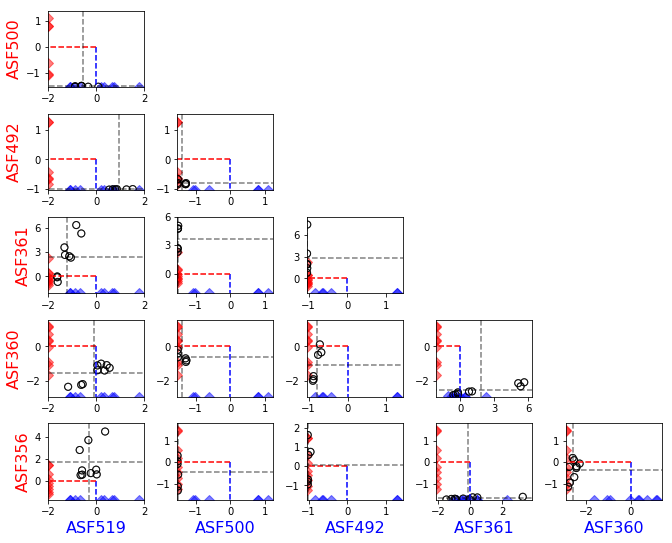

In [8]:
fig,axes = plt.subplots(5,5)

axes = np.ravel((axes))
species_used = []
for species_1 in species:
    species_used.append(species_1)
    species_1_df = master[master['species'] == species_1][species_1+'Z']
    
    for species_2 in species:
        if species_2 not in species_used:
            coculture = species_1 + ';' + species_2
            species_2_df = master[master['species'] == species_2][species_2+'Z']
            # get value for species 1 z-scores in species 2 samples
            species_1_cross = master[master['species'] == species_2][species_1+'Z']
            # get value for species 2 z-scores in species 1 samples
            species_2_cross = master[master['species'] == species_1][species_2+'Z']
            # get z scores for each species from coculture
            spec1_z_coculture = master[master['species'] == coculture][species_1+'Z']
            spec2_z_coculture = master[master['species'] == coculture][species_2+'Z']

             
            ax_index = position_dict[str([species_1,species_2])]
            ax = axes[ax_index][0]
            ax.scatter(species_2_cross,species_1_df,color='red',alpha=0.5,s=50,marker='D')
            ax.scatter(species_2_df,species_1_cross,color='blue',alpha=0.5,s=50,marker='D')
            ax.scatter(spec2_z_coculture,spec1_z_coculture,color='black',alpha=0.75,s=50,marker='o',facecolors="None")
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            ax.plot(np.array([0,0]),np.array([0,ylim[0]]),'--',color='blue')#,alpha=0.5)
            ax.plot(np.array([0,xlim[0]]),np.array([0,0]),'--',color='red')#,alpha=0.5)
            # plot the mean and std. dev of the coculture as lines from the axes
            ax.plot(np.array([xlim[0],xlim[1]]),np.array([spec1_z_coculture.mean(),spec1_z_coculture.mean()]),'--',color='black',alpha=0.5)
            ax.plot(np.array([spec2_z_coculture.mean(),spec2_z_coculture.mean()]),np.array([ylim[1],ylim[0]]),'--',color='black',alpha=0.5)
            s1_stdev = spec1_z_coculture.std()
            s2_stdev = spec2_z_coculture.std()
            #ax.add_patch(patches.Rectangle((spec1_z_coculture.mean()-s1_stdev,ylim[0]),2*s1_stdev,spec2_z_coculture.mean()-ylim[0]))
            # reset the limits to match the minimum z-score for the other species (so monocultures are on axis)
            new_lower_y_lim = min(species_1_cross)
            new_lower_x_lim = min(species_2_cross)
            ax.set_xlim((new_lower_x_lim,xlim[1]))
            ax.set_ylim((new_lower_y_lim,ylim[1]))
            
            # force tick labels to be at integers only
            ya = ax.get_yaxis()
            ya.set_major_locator(MaxNLocator(integer=True))
            xa = ax.get_xaxis()
            xa.set_major_locator(MaxNLocator(integer=True))
            ax.locator_params(nbins=4)
# delete the unused axes
for ax_index in unnocupied:
    fig.delaxes(axes[ax_index])

# Add text labels indicating species
axes[0].set_ylabel('ASF500',fontsize=16,color='red')
axes[5].set_ylabel('ASF492',fontsize=16,color='red')
axes[10].set_ylabel('ASF361',fontsize=16,color='red')
axes[15].set_ylabel('ASF360',fontsize=16,color='red')
axes[20].set_ylabel('ASF356',fontsize=16,color='red')

axes[20].set_xlabel('ASF519',fontsize=16,color='blue')
axes[21].set_xlabel('ASF500',fontsize=16,color='blue')
axes[22].set_xlabel('ASF492',fontsize=16,color='blue')
axes[23].set_xlabel('ASF361',fontsize=16,color='blue')
axes[24].set_xlabel('ASF360',fontsize=16,color='blue')

#fig.locator_params(nticks=4)
fig.subplots_adjust(wspace=.35,hspace=0.35)
fig.set_size_inches(11,9)
plt.savefig('../results/qPCR_grid_20171115.svg',format='svg')

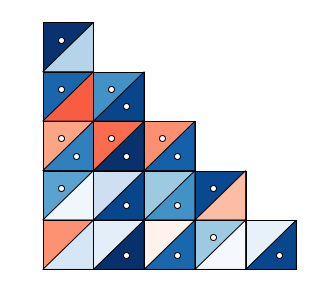

In [9]:
fig, ax = plt.subplots()
species_used = []
gridsize = 5 # grid will be 5x5 because we have 6 species
x_count = 0
y_count = 0
sig_thresh = 0.05
red_cmap = plt.get_cmap('Reds')
blue_cmap = plt.get_cmap('Blues')
for species_1 in species:
    species_used.append(species_1)
    species_1_df = master[master['species'] == species_1][species_1+'Z']
    
    for species_2 in species:
        if species_2 not in species_used:
            coculture = species_1 + ';' + species_2
            species_2_df = master[master['species'] == species_2][species_2+'Z']
            # get value for species 1 z-scores in species 2 samples
            species_1_cross = master[master['species'] == species_2][species_1+'Z']
            # get value for species 2 z-scores in species 1 samples
            species_2_cross = master[master['species'] == species_1][species_2+'Z']
            # get z scores for each species from coculture
            spec1_z_coculture = master[master['species'] == coculture][species_1+'Z']
            spec2_z_coculture = master[master['species'] == coculture][species_2+'Z']

            # determine the grid position for this combination
            grid_x_pos = 1 - x_count/gridsize
            grid_y_pos = y_count/gridsize
            
            # scale the z-scores from 0 to max
            upper_abundance = spec1_z_coculture.mean()/master[master['species'].str.find(species_1) > -1][species_1+'Z'].abs().max()
            lower_abundance = spec2_z_coculture.mean()/master[master['species'].str.find(species_2) > -1][species_2+'Z'].abs().max()

            # Get the value on the colormap for the co-culture abundance z-scores
            if upper_abundance > 0:
                upper_color = red_cmap(upper_abundance)
            else:
                upper_color = blue_cmap(-1.0*upper_abundance)

            if lower_abundance > 0:
                lower_color = red_cmap(lower_abundance)
            else:
                lower_color = blue_cmap(-1.0*lower_abundance)
            
            # upper left will be the x-label species, lower right will be the y-label species
            upper_triangle = Polygon(((grid_x_pos,grid_y_pos+1/gridsize),(grid_x_pos-1/gridsize,grid_y_pos+1/gridsize),(grid_x_pos-1/gridsize,grid_y_pos)),\
                       closed=True,edgecolor='black',facecolor=upper_color)
            # add expected triangle here:
            lower_triangle = Polygon(((grid_x_pos,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos),(grid_x_pos,grid_y_pos+1/gridsize)),\
                       closed=True,edgecolor='black',facecolor=lower_color)
            outline_rectangle = Polygon(((grid_x_pos,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos+1/gridsize),(grid_x_pos,grid_y_pos+1/gridsize)),\
                        closed=True,edgecolor='black',facecolor='none')
            plt.gca().add_patch(upper_triangle)
            plt.gca().add_patch(lower_triangle)
            plt.gca().add_patch(outline_rectangle)
            
            # get the result of the significance test (observed vs. expected) to annotate the plot
            upper_p = all_diff_abundance.loc[(all_diff_abundance['mono_comparison'] == species_1) &\
                       (all_diff_abundance['species'] == species_1+';'+species_2),]['final_p'].values[0]
            lower_p = all_diff_abundance.loc[(all_diff_abundance['mono_comparison'] == species_2) &\
                       (all_diff_abundance['species'] == species_1+';'+species_2),]['final_p'].values[0]
            if upper_p < sig_thresh:
                note = ax.plot(grid_x_pos-0.65*1/gridsize, grid_y_pos+0.65*1/gridsize,'o',color='white',markeredgecolor='black')
            if lower_p < sig_thresh:
                note = ax.plot(grid_x_pos-0.35*1/gridsize, grid_y_pos+0.3*1/gridsize,'o',color='white',markeredgecolor='black')
                
            
            x_count+=1
            if x_count == gridsize:
                y_count += 1 # go up one level
                x_count = 0 + y_count # reset to the rightmost x position at the new y level
fig.set_size_inches(5,5)
ax.axis('off')
plt.savefig('../results/coculture_abundance_triangle_heatmap.svg', bbox_inches='tight')


In [10]:
master

,Harvest Date,Run,Plate,Column (1-4),Row (A-B),species,normalized_OD,356,360,361,...,356Z,360Z,361Z,492Z,500Z,519Z,final_p,w_stat_vector,diff_vector,mono_comparison
0,2017-01-10,1,1,1,A,356,0.164567,1.737581e+00,0.000000,0.000000,...,-1.018914,-2.893424,-2.092789,-1.047840,-1.523061,-2.011943,NaN,NaN,NaN,NaN
1,2017-01-10,1,1,1,B,356,0.173767,2.395354e+00,0.000000,0.000000,...,-0.741771,-2.893424,-2.092789,-1.047840,-1.523061,-2.011945,NaN,NaN,NaN,NaN
2,2017-01-10,1,1,1,C,356,0.186067,1.225792e+00,0.000000,0.000008,...,-1.234548,-2.893424,-2.092769,-1.047840,-1.523061,-2.011945,NaN,NaN,NaN,NaN
3,2017-01-11,2,1,1,A,356,0.178458,3.063198e+00,0.000003,0.000000,...,-0.460384,-2.893418,-2.092789,-1.047840,-1.523061,-2.011945,NaN,NaN,NaN,NaN
4,2017-01-11,2,1,1,B,356,0.170958,3.619080e+00,0.000054,0.000000,...,-0.226172,-2.893299,-2.092789,-1.047840,-1.523055,-2.011945,NaN,NaN,NaN,NaN
5,2017-01-11,2,1,1,C,356,0.171858,4.588871e+00,0.000008,0.000021,...,0.182435,-2.893405,-2.092739,-1.047840,-1.523061,-2.011945,NaN,NaN,NaN,NaN
6,2017-01-12,3,1,1,A,356,0.192092,7.573429e+00,0.000000,0.000000,...,1.439934,-2.893424,-2.092789,-1.047840,-1.523061,-2.011945,NaN,NaN,NaN,NaN
7,2017-01-12,3,1,1,B,356,0.185192,7.657333e+00,0.000010,0.000000,...,1.475286,-2.893401,-2.092789,-1.047838,-1.523061,-2.011945,NaN,NaN,NaN,NaN
8,2017-01-12,3,1,1,C,356,0.178592,5.542265e+00,0.000000,0.000000,...,0.584133,-2.893424,-2.092789,-1.047840,-1.523061,-2.011945,NaN,NaN,NaN,NaN
9,2017-01-10,1,1,2,A,360,0.012467,1.045561e-05,1.239476,0.000017,...,-1.751013,-0.022590,-2.092749,-1.047834,-1.523061,-2.011945,NaN,NaN,NaN,NaN


356
MannwhitneyuResult(statistic=311.0, pvalue=0.23793661740111438)
360
MannwhitneyuResult(statistic=97.0, pvalue=0.00016433127378176436)
361
MannwhitneyuResult(statistic=274.0, pvalue=0.11301490012549925)
492
MannwhitneyuResult(statistic=142.0, pvalue=0.16095753225202408)
500
MannwhitneyuResult(statistic=162.0, pvalue=0.28620842254734169)
519
MannwhitneyuResult(statistic=294.0, pvalue=0.17319458498901147)


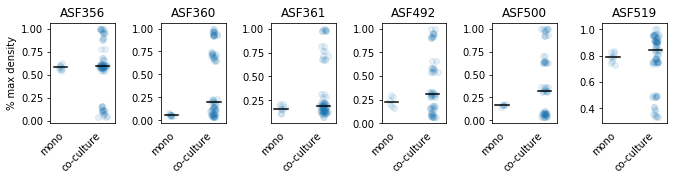

In [11]:
# Compare single species abundance to co-culture abundance.
# For each species, generate a new dataframe that is a subset of master, then add a column indicating a 
# biomass z-score calculated using the monoculture abundance.
fig,axes=plt.subplots(1,6)

i = 0
shift = 0.5
median_width = 0.08
for specie in species:
    print(specie)
    subset = master.loc[master['species'].str.find(specie) > -1,]
    monocultures = subset.loc[subset['species'] == specie]['normalized_OD']
    cocultures = subset.loc[subset['species'] != specie]['normalized_OD']
    mono_z = monocultures/max(monocultures.max(),cocultures.max())
    coculture_z = cocultures/max(monocultures.max(),cocultures.max())
    # compute mann-whitney rank test
    print(scipy.stats.mannwhitneyu(mono_z,coculture_z))
    
    x = np.append(np.zeros(len(mono_z)),(np.zeros(len(coculture_z))+shift))
    x = x + np.random.normal(0,0.02,len(x)) # add some jitter to x for plotting
    y = np.append(mono_z,coculture_z)
    ax=axes[i]
    ax.scatter(x,y,alpha=0.1)
    ax.plot([-median_width,median_width],[np.median(mono_z),np.median(mono_z)],'black')
    ax.plot([shift-median_width,shift+median_width],[np.median(coculture_z),np.median(coculture_z)],'black')
    ax.set_title('ASF'+specie)
    ax.tick_params(
        axis='x',
        which='both',
        top='off',
        bottom='off'
    )
    ax.set_xticks([0-0.2*shift,shift-0.5*shift])
    ax.set_xticklabels(labels=['mono','co-culture'],rotation=45)
    
    
    if i == 0:
        ax.set_ylabel('% max density')
    i +=1
fig.tight_layout(w_pad=0.1)
fig.set_size_inches(10,2)
plt.savefig('../results/mono_vs_coculture_density.svg', bbox_inches='tight')


356
MannwhitneyuResult(statistic=149.0, pvalue=0.011236521698537777)
360
MannwhitneyuResult(statistic=93.0, pvalue=0.00060628444256338938)
492
MannwhitneyuResult(statistic=70.0, pvalue=0.015934694036802401)
500
MannwhitneyuResult(statistic=90.0, pvalue=0.051996990274214817)
519
MannwhitneyuResult(statistic=132.0, pvalue=0.0050601075334345607)


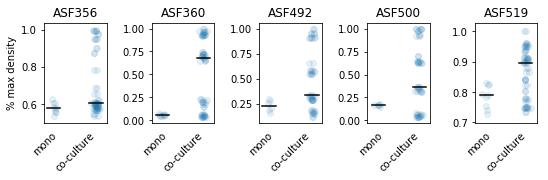

In [12]:
# Do the same with 361 excluded
fig,axes=plt.subplots(1,5)

i = 0
shift = 0.5
median_width = 0.08
species_no_361  = ['356','360','492','500','519']
for specie in species_no_361:
    print(specie)
    subset = master.loc[master['species'].str.find(specie) > -1,]
    subset = subset.loc[subset['species'].str.find('361') < 0,] # remove all the co-culture that contained 361
    monocultures = subset.loc[subset['species'] == specie]['normalized_OD']
    cocultures = subset.loc[subset['species'] != specie]['normalized_OD']
    mono_z = monocultures/max(monocultures.max(),cocultures.max())
    coculture_z = cocultures/max(monocultures.max(),cocultures.max())
    # compute mann-whitney rank test
    print(scipy.stats.mannwhitneyu(mono_z,coculture_z))
    x = np.append(np.zeros(len(mono_z)),(np.zeros(len(coculture_z))+shift))
    x = x + np.random.normal(0,0.02,len(x))
    y = np.append(mono_z,coculture_z)
    ax=axes[i]
    ax.scatter(x,y,alpha=0.1)
    ax.plot([-median_width,median_width],[np.median(mono_z),np.median(mono_z)],'black')
    ax.plot([shift-median_width,shift+median_width],[np.median(coculture_z),np.median(coculture_z)],'black')
    ax.set_title('ASF'+specie)
    ax.tick_params(
        axis='x',
        which='both',
        top='off',
        bottom='off'
    )
    ax.set_xticks([0-0.2*shift,shift-0.5*shift])
    ax.set_xticklabels(labels=['mono','co-culture'],rotation=45)
    if i == 0:
        ax.set_ylabel('% max density')
    i += 1
fig.tight_layout(w_pad=0.1)
fig.set_size_inches(8,2)
plt.savefig('../results/mono_vs_coculture_density_no361.svg', bbox_inches='tight')
